In [2]:
"""
Noor Seijdel, 2017
"""
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import os.path 
import hddm
from scipy.stats import pearsonr, percentileofscore, ttest_ind, ttest_rel, wilcoxon, ranksums
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.pyplot as plt
from patsy import center
import kabuki
%matplotlib inline 

mdir = '/home/nseijde1/scenestats/hddmregression'

In [5]:
# test parallel
import ipyparallel as ipp
c = ipp.Client()
c.ids
c[:].apply_sync(lambda : "test")

['test', 'test', 'test', 'test']

In [3]:
def run_model(id):
    import hddm
    import os.path
    
    #exp1, 2a, 2b
    data = hddm.load_csv('/home/nseijde1/scenestats/hddm/scce_hddm/SCCE_def.csv') 
    #data = hddm.load_csv('/home/nseijde1/scenestats/hddm/sc_hddm/SC_def.csv') 
    #data = hddm.load_csv('/home/nseijde1/scenestats/hddm/ce_hddm/CE_def.csv') 
    
    #model0, 1, 2, 3, 4
    #m0 = hddm.HDDM(data, bias=False, p_outlier=0.05)
    dep = {'a':'SpAc'} #1
    #dep = {'v':'Sc', 'a':'SpAc'} #2
    #dep = {'a':['SpAc', 'Sc']} #3
    #dep = {'v':'Sc', 'a':['SpAc', 'Sc']} #4

    os.chdir(u'/home/nseijde1')
    m = hddm.HDDM(data,depends_on=dep, bias=False, p_outlier=0.05)
    m.find_starting_values()
    m.sample(5000, burn=20, thin=2, dbname='traces%i.db'%id, db='pickle')
    return m

In [4]:
jobs = c[:].map(run_model, range(4)) # 4 is the number of CPUs
models = jobs.get()

## Combine traces + save model in right folder 

                   mean         std       2.5q        25q        50q        75q      97.5q       mc err
a               1.16148   0.0413559    1.08375    1.13417    1.16015    1.18753    1.24728   0.00047079
a_std          0.177016   0.0331445   0.125577   0.153709   0.172751   0.195242   0.255706  0.000394878
a_subj.ppn1     1.20975   0.0254184    1.16267    1.19231    1.20908    1.22635     1.2612  0.000323425
a_subj.ppn10    1.21355   0.0358006    1.14535    1.18933    1.21278    1.23724    1.28557  0.000558701
a_subj.ppn11    1.18842   0.0345305     1.1255    1.16435    1.18731    1.21142    1.25891  0.000546878
a_subj.ppn12    1.12402   0.0213437     1.0838    1.10932    1.12368    1.13841    1.16664  0.000250914
a_subj.ppn13    1.40263   0.0266956    1.35209    1.38407    1.40205    1.42015    1.45669  0.000315352
a_subj.ppn14    1.02718   0.0226841   0.983407    1.01171    1.02659     1.0423    1.07289  0.000300533
a_subj.ppn15    1.16282   0.0320359     1.1032     1.1403    1.1

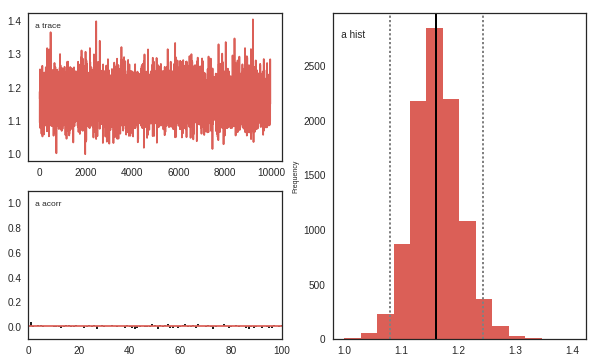

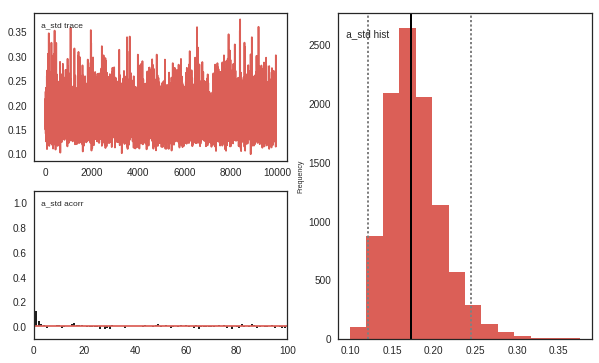

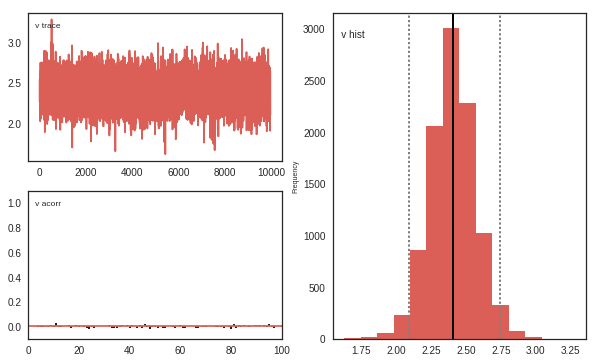

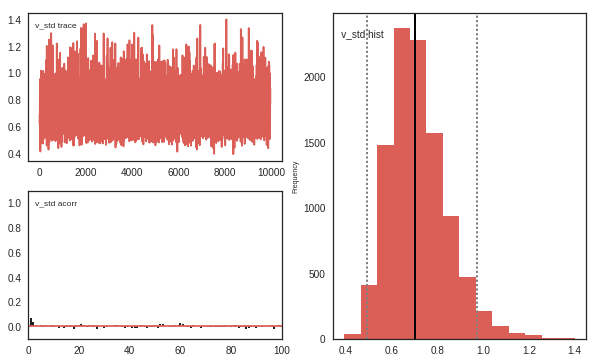

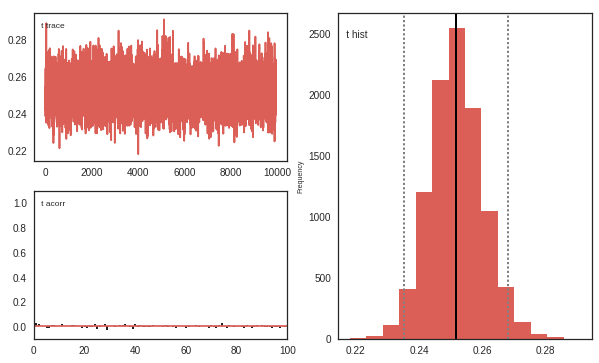

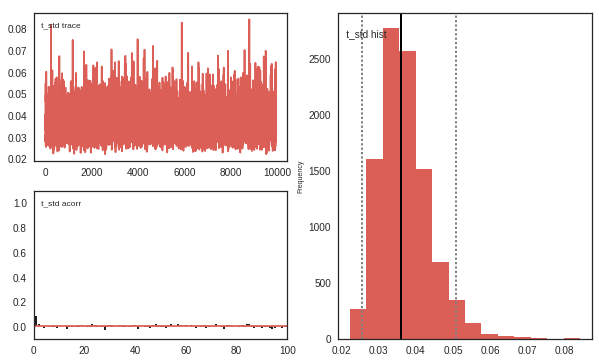

In [7]:
combined_model = kabuki.utils.concat_models(models) #combine traces
os.chdir(u'/home/nseijde1/scenestats/hddmcheck/exp1/m') #save model in correct folder
combined_model.save('m')
#combined_model.print_stats()
combined_model.plot_posteriors(save=True)

In [ ]:
# gelman rubic:
gr = hddm.analyze.gelman_rubin(combined_model)
text_file = open(os.path.join(mdir, 'gelmanrubin.txt'), 'w')
for p in gr.items():
    text_file.write("%s:%s\n" % p)
    text_file.close()

# dic:
text_file = open(os.path.join(mdir, 'dic.txt'), 'w')
text_file.write("Model {}: {}\n".format(0, combined_model.dic))
text_file.close()